# Diet Data Editor
Author: Brent Artuch <br>
Date: 2023-06-04

## Introduction

This notebook depicts the process of adding new food entries to my SQLite database and then takes you
through the macronutrient conversion calculations. After the caloric intake based on macro nutrient for
the day has been calculated, we then proceed to a few visualizations for those calculations. <br>

This document utilizes an array of Pandas processing techniques such as filtering via boolean masking,
using descriptive methods to illustrate the shape of the data set, and creating visualizations using the
data in the dataframe.

## Step: 1 Imports
### Import packages

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns

### Load the dataset
This dataset is pulled from a SQLite database that stores all foods I have consumed by `month_YYYY`. We will
load the current month using a simple query.

In [2]:
sql_connection = sqlite3.connect('diet.sqlite')
# Import the desired table and set the index.
current_foods = pd.read_sql('SELECT * FROM june_2023', sql_connection, index_col='index')
current_foods.tail(10)

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
234,1000468,2023-06-28 00:00:00,2,Protein Powder,2.0,3.0,2.0,24,120
235,1000469,2023-06-28 00:00:00,2,Butter,1.0,0.0,11.0,0,100
236,1000470,2023-06-28 00:00:00,3,Quarter Pounder,2.0,42.0,26.0,30,520
237,1000471,2023-06-28 00:00:00,3,Gatorade Powder,2.0,22.0,0.0,0,80
238,1000472,2023-06-28 00:00:00,4,Ice Cream Sandwich,1.0,26.0,5.0,2,160
239,1000473,2023-06-28 00:00:00,4,Protein Powder,2.0,3.0,2.0,24,120
240,1000474,2023-06-29 00:00:00,1,Ramen,1.0,54.0,14.0,8,370
241,1000475,2023-06-29 00:00:00,1,Protein Powder,2.0,3.0,2.0,24,120
242,1000476,2023-06-29 00:00:00,2,Gyro,1.0,73.0,12.0,44,593


## Step 2: Data Exploration
Next we will get a sense of the size and contents of `current_foods`.

In [3]:
current_foods.shape

(244, 9)

In [4]:
current_foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 243
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   food_id      244 non-null    int64  
 1   date         244 non-null    object 
 2   meal_number  244 non-null    int64  
 3   food_name    244 non-null    object 
 4   servings     244 non-null    float64
 5   carbs        244 non-null    float64
 6   fats         244 non-null    float64
 7   protein      244 non-null    int64  
 8   calories     244 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 19.1+ KB


In [5]:
current_foods[['carbs','fats','protein','calories']].describe()

,carbs,fats,protein,calories
count,244.000000,244.000000,244.000000,244.000000
mean,23.471311,7.016393,11.278689,200.028689
std,22.254495,10.208915,12.987339,180.334677
min,0.000000,0.000000,0.000000,70.000000
25%,3.000000,2.000000,1.000000,90.000000
50%,17.000000,3.000000,4.000000,120.000000
75%,42.000000,9.000000,24.000000,210.000000
max,111.000000,81.000000,88.000000,1400.000000


In [6]:
current_foods['food_name'].value_counts().head()

Protein Powder     56
Rice               21
Fruit Snacks       18
Spicy Garlic       17
Gatorade Powder    11
Name: food_name, dtype: int64

## Step 3: Update the Dataset
### Load the master food list
First we will load the names of the foods from the master `food_list` database so that the algorithm
can check against the list for whether the food reference exists.

In [7]:
# Call the primary food list.
food_db = pd.read_sql('SELECT food_name FROM food_list', sql_connection)
food_db.head()

,food_name
0,Oatmeal
1,Protein Powder
2,Coco Powder
3,Ramen
4,Cereal Bar


### Set the date of the entries

In [8]:
# TODO: Get month and year using datetime

day_of_month = input("Enter the day of the month: DD")
date = f"2023-06-{day_of_month} 00:00:00"
date

'2023-06-29 00:00:00'

### Execute the entry insertion algorithm

In [25]:
# Set the current meal number to be logged
choice = 1
foods = list(food_db['food_name'])

while choice != 2:

    """ This algorithm takes a desired food input and then inserts it into a SQL query to
    retrieve the nutritional info for that food. The meal number and serving count are
     updated and then the entry is inserted into the dataframe. """

    db_food = input("What food would you like too add?")
    if db_food not in foods:
        raise Exception(input("Food not in database. Try again: "))
    new_food = pd.read_sql("SELECT food_name, carbs, fats, protein, calories"
                            " FROM food_list "
                            " WHERE food_name = (?)", sql_connection, params=(db_food,))
    meal_number = int(input("Enter Meal Number: "))
    servings = float(input("Enter Serving Count: "))
    f_id = current_foods.iloc[-1, 0] + 1
    new_entry = [f_id,
                 date,
                 meal_number,
                 new_food.loc[0,'food_name'],
                 servings,
                 new_food.loc[0,'carbs'],
                 new_food.loc[0,'fats'],
                 new_food.loc[0,'protein'],
                 new_food.loc[0,'calories']]
    current_foods.loc[len(current_foods)] = new_entry
    choice = int(input("Add another? [1]Yes [2]No"))

current_foods['date'] = pd.to_datetime(current_foods['date'])
updated_foods = current_foods
updated_foods.tail(10)

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
239,1000473,2023-06-28,4,Protein Powder,2.0,3.0,2.0,24,120
240,1000474,2023-06-29,1,Ramen,1.0,54.0,14.0,8,370
241,1000475,2023-06-29,1,Protein Powder,2.0,3.0,2.0,24,120
242,1000476,2023-06-29,2,Gyro,1.0,73.0,12.0,44,593
243,1000477,2023-06-29,2,Wendys Jr Fries,2.0,28.0,9.0,3,210
244,1000478,2023-06-29,3,Rice,1.0,45.0,1.0,4,206
245,1000479,2023-06-29,3,Spicy Garlic,2.0,3.0,6.0,1,70
246,1000480,2023-06-29,3,Protein Powder,2.0,3.0,2.0,24,120
247,1000481,2023-06-29,4,Ice Cream Sandwich,1.0,26.0,5.0,2,160


### Data Manipulation
This section exists for convenience if quick changes need to be made to the entries.

In [20]:
# Update item(s) by index and column
# current_foods.loc[158,'servings'] = 2.0
# Drop operation
# current_foods.drop(index=current_foods.index[-1], axis=0, inplace=True) # Remove last entry
updated_foods.tail()

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
243,1000477,2023-06-29,2,Wendys Jr Fries,2.0,28.0,9.0,3,210
244,1000478,2023-06-29,3,Rice,1.0,45.0,1.0,4,206
245,1000479,2023-06-29,3,Spicy Garlic,2.0,3.0,6.0,1,70
246,1000480,2023-06-29,3,Protein Powder,2.0,3.0,2.0,24,120
247,1000481,2023-06-29,4,Ice Cream Sandwich,1.0,26.0,5.0,2,160


## Step 4: Daily Macro Calculations
### Filter out all entries besides those with today's date.

In [26]:
# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
240,1000474,2023-06-29,1,Ramen,1.0,54.0,14.0,8,370
241,1000475,2023-06-29,1,Protein Powder,2.0,3.0,2.0,24,120
242,1000476,2023-06-29,2,Gyro,1.0,73.0,12.0,44,593
243,1000477,2023-06-29,2,Wendys Jr Fries,2.0,28.0,9.0,3,210
244,1000478,2023-06-29,3,Rice,1.0,45.0,1.0,4,206
245,1000479,2023-06-29,3,Spicy Garlic,2.0,3.0,6.0,1,70
246,1000480,2023-06-29,3,Protein Powder,2.0,3.0,2.0,24,120
247,1000481,2023-06-29,4,Ice Cream Sandwich,1.0,26.0,5.0,2,160
248,1000482,2023-06-29,4,Fruit Snacks,1.0,17.0,0.0,1,70


### Macro Calculations
These calculations assist in assessing the required macro nutrients for the day and possible adjustments
that need to made if carbs or fats have exceeded or come up short of their targets.

In [27]:
# Calculate macronutrient totals based on serving count
total_carbs = int((today['carbs'] * today['servings']).sum())
total_fats = int((today['fats'] * today['servings']).sum())
total_protein = int((today['protein'] * today['servings']).sum())
total_cals = int((today['calories'] * today['servings']).sum())

print(f"Carbs: {total_carbs} | Goals: 525 425 325")
print(f"Fats: {total_fats} | Goals: 100 75 50")
print(f"Protein: {total_protein} | Goal: 200")
print(f"Calories: {total_cals}")

Carbs: 289 | Goals: 525 425 325
Fats: 70 | Goals: 100 75 50
Protein: 163 | Goal: 200
Calories: 2439


### Convert the macro nutrients to their caloric measurement.

In [28]:
# Calculate the number of calories from each macro nutrient.
carb_cals = total_carbs * 4
fat_cals = total_fats * 9
non_protein_cals = carb_cals + fat_cals
large_goal_npc = (525*4)+(100*9)
small_goal_npc = (425*4)+(75*9)
rest_goal_npc = (325*4)+(50*9)
goal = rest_goal_npc # large_goal_npc OR small_goal_npc OR rest_goal_npc
cal_difference = abs(goal-non_protein_cals)
protein_cals = total_protein * 4

print(f"Calories From Carbs: {carb_cals}")
print(f"Calories From Fats: {fat_cals}")
print(f"Non-Protein Calories: {non_protein_cals} Goal: {goal}")
print(f"Calorie Difference: {cal_difference}")
print(f"Calories From Protein: {protein_cals}")

Calories From Carbs: 1156
Calories From Fats: 630
Non-Protein Calories: 1786 Goal: 1750
Calorie Difference: 36
Calories From Protein: 652


### Update SQL
Now that we have updated our table, we will export the new dataset to SQL. As a precaution, I always
back up the new dataset to CSV in the event that an unforeseen reset is required in the future.

In [29]:
updated_foods.to_sql('june_2023', sql_connection, if_exists='replace')

249

In [30]:
updated_foods.to_csv(r'/Users/tukles/Library/CloudStorage/GoogleDrive-brent.artuch@gmail.com/My Drive/CSV/june_2023.csv')

## Step 5: Visualize the Data
Portray the macro nutrient dispersion of calories as a pie chart.

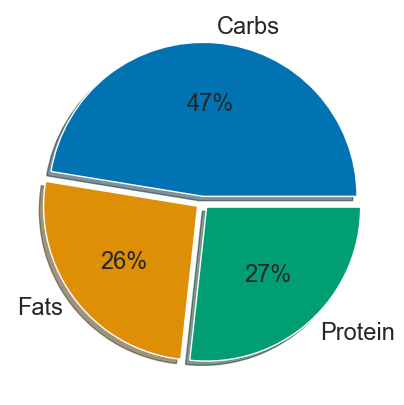

In [31]:
# Plot as a pie chart
macro_series = pd.Series(
    [carb_cals, fat_cals, protein_cals],
    index=['Carbs', 'Fats', 'Protein'],
    name=""
)

macro_series.plot.pie(
    colors=sns.color_palette('colorblind'),
    autopct='%1.0f%%',
    fontsize=17,
    shadow=True,
    explode=(0.04,0.04,0.04),
    figsize=(5,5)
);

##### Add a new `total_food_cals` column that is the product of the food entry servings by its `calories`.

In [32]:
# Add a total calories column
updated_foods['total_food_cals'] = updated_foods['servings'] * updated_foods['calories']

# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories,total_food_cals
index,,,,,,,,,,
240,1000474,2023-06-29,1,Ramen,1.0,54.0,14.0,8,370,370.0
241,1000475,2023-06-29,1,Protein Powder,2.0,3.0,2.0,24,120,240.0
242,1000476,2023-06-29,2,Gyro,1.0,73.0,12.0,44,593,593.0
243,1000477,2023-06-29,2,Wendys Jr Fries,2.0,28.0,9.0,3,210,420.0
244,1000478,2023-06-29,3,Rice,1.0,45.0,1.0,4,206,206.0
245,1000479,2023-06-29,3,Spicy Garlic,2.0,3.0,6.0,1,70,140.0
246,1000480,2023-06-29,3,Protein Powder,2.0,3.0,2.0,24,120,240.0
247,1000481,2023-06-29,4,Ice Cream Sandwich,1.0,26.0,5.0,2,160,160.0
248,1000482,2023-06-29,4,Fruit Snacks,1.0,17.0,0.0,1,70,70.0


##### Group the entries by `meal_number` and aggregate the corresponding `total_food_cals` to get `cals_per_meal`

In [33]:
cals_per_meal = today.groupby(today['meal_number']).aggregate({'total_food_cals': 'sum'})
cals_per_meal.reset_index()
cals_per_meal

,total_food_cals
meal_number,
1,610.0
2,1013.0
3,586.0
4,230.0


### Plot the calories per meal
Ideally the line should be as level as possible over four meals.

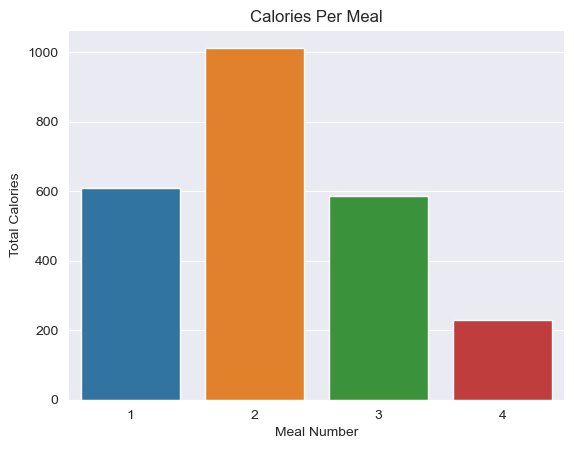

In [34]:
fig = sns.barplot(data=cals_per_meal, x=cals_per_meal.index,y='total_food_cals')
fig.set(title="Calories Per Meal", xlabel="Meal Number", ylabel="Total Calories");

## LOG:
### 2023-05-15: Wine removed from diet
### 2023-05-29: New Cal Goals 500 400 300